In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 02. Baseline

**Variable objetivo (pobj)**

- `pobj` representa algo como la capacidad portante óptima (o la función objetivo del problema de optimización).

- Es un valor continuo, ya que representa un nivel máximo de carga o rendimiento estructural.



Por eso se modela con regresión: se quiere predecir cuánto puede soportar la estructura según los parámetros de entrada.

**Variables predictoras** (p, gray_level, problem_type, criterion, pmax, iteration, experiment)

- Son parámetros del problema de optimización que afectan el resultado.

- Se usan para entrenar modelos que estimen pobj sin tener que resolver el problema de optimización completo cada vez.

**Métricas usadas:** `MAE`, `RMSE` y `R²` son apropiadas porque medimos diferencias entre valores continuos reales y predichos.

Importar librerías.

In [3]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
from itertools import zip_longest

Cargar los datos.

In [4]:
# Carga
df = pd.read_csv('drive/MyDrive/Project/results/eda_results.csv')

# Evitamos variables que generan leakage
X = df.drop(columns=['pobj', 'iteration'])
y = df['pobj']


Pre-procesamiento y modelo.

In [5]:
# Pre-procesamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalado (necesario para KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    "Regresión Lineal": LinearRegression(),
    "KNN (k=5)": KNeighborsRegressor(n_neighbors=5)
}

Métricas + Predicción vs valor real

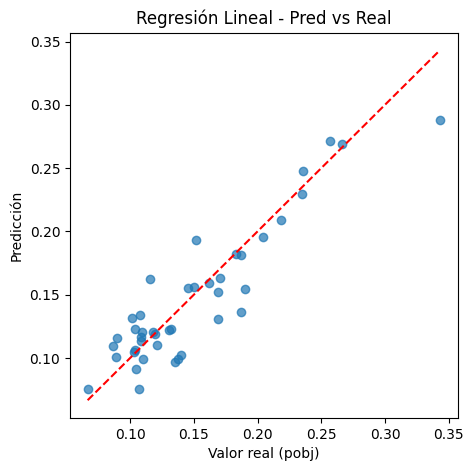

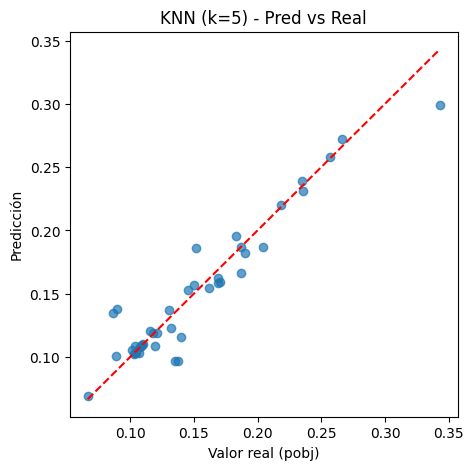

In [6]:
results = []

for name, model in models.items():
    if "KNN" in name:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append([name, mae, rmse, r2])

    plt.figure(figsize=(5,5))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Valor real (pobj)")
    plt.ylabel("Predicción")
    plt.title(f"{name} - Pred vs Real")
    plt.savefig(f'drive/MyDrive/Project/results/images/Baseline/pred_vs_real_{name}.png')
    plt.show()

_Se seleccionó K=5 como valor inicial por ser una configuración estándar en problemas con tamaño de muestra reducido (~209 observaciones)_

Resumen de métricas.

In [7]:
results_df = pd.DataFrame(results, columns=["Modelo", "MAE", "RMSE", "R2"])
print(results_df)

             Modelo       MAE      RMSE        R2
0  Regresión Lineal  0.017726  0.023279  0.832562
1         KNN (k=5)  0.011196  0.017893  0.901085


Exportación de métricas.

In [8]:
results_df.to_csv('drive/MyDrive/Project/results/baseline_metrics.csv', index=False)
print("Métricas exportadas exitosamente.")

Métricas exportadas exitosamente.


## **CONCLUSIONES**

- Se probaron dos modelos simples: **Regresión Lineal** y **KNN (k=5)**.  
- El **KNN (k=5)** tuvo mejor desempeño (R² ≈ 0.91), mostrando que la relación no es completamente lineal.  
- Los errores fueron bajos, lo que indica un buen punto de partida.  
- En el siguiente paso se aplicará validación cruzada e ingeniería de características para mejorar los resultados.
